In [21]:
import pandas as pd

# Cargar los datos desde los archivos CSV
cash_requests_df = pd.read_csv('../../project-1-ironhack-payments-es/project_dataset/extract - cash request - data analyst.csv')
fees_df = pd.read_csv('../../project-1-ironhack-payments-es/project_dataset/extract - fees - data analyst - .csv')

# Convertir las fechas a formato datetime y establecer UTC como la zona horaria
cash_requests_df['created_at'] = pd.to_datetime(cash_requests_df['created_at'], utc=True)
fees_df['created_at'] = pd.to_datetime(fees_df['created_at'], utc=True)

# Crear la columna de cohorte basada en el mes y año de la primera solicitud de efectivo de cada usuario
cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


/var/folders/8d/_dfy3v191xq4fpx56kpljr380000gn/T/ipykernel_4767/3964886653.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


In [22]:
# Filtrar los datos de tarifas para obtener solo los incidentes de pago
incident_fees = fees_df[fees_df['type'] == 'incident']

# Relacionar los incidentes de tarifas con las solicitudes de efectivo por 'cash_request_id'
incident_counts = incident_fees.groupby('cash_request_id').size().reset_index(name='incident_count')
cash_requests_df = cash_requests_df.merge(incident_counts, left_on='id', right_on='cash_request_id', how='left')

# Asignar 0 a las solicitudes sin incidentes para asegurar una correcta agregación
cash_requests_df['incident_count'].fillna(0, inplace=True)

In [23]:
# Calcular la tasa de incidentes por cohorte y el total de incidentes y solicitudes
cohort_incidents = cash_requests_df.groupby('cohort').agg(
    total_incidents=('incident_count', 'sum'),
    total_requests=('id', 'count')
)
cohort_incidents['incident_rate'] = cohort_incidents['total_incidents'] / cohort_incidents['total_requests']

# Imprimir el resultado final con mejor formato
print(cohort_incidents[['total_incidents', 'total_requests', 'incident_rate']])

         total_incidents  total_requests  incident_rate
cohort                                                 
2019-11              0.0               8       0.000000
2019-12             42.0             893       0.047032
2020-01             21.0             321       0.065421
2020-02             24.0             423       0.056738
2020-03             29.0             323       0.089783
2020-04            113.0             840       0.134524
2020-05            204.0            1449       0.140787
2020-06            697.0            4711       0.147952
2020-07            542.0            3735       0.145114
2020-08            145.0            1510       0.096026
2020-09            190.0            2636       0.072079
2020-10             23.0            4943       0.004653
2020-11              0.0              75       0.000000


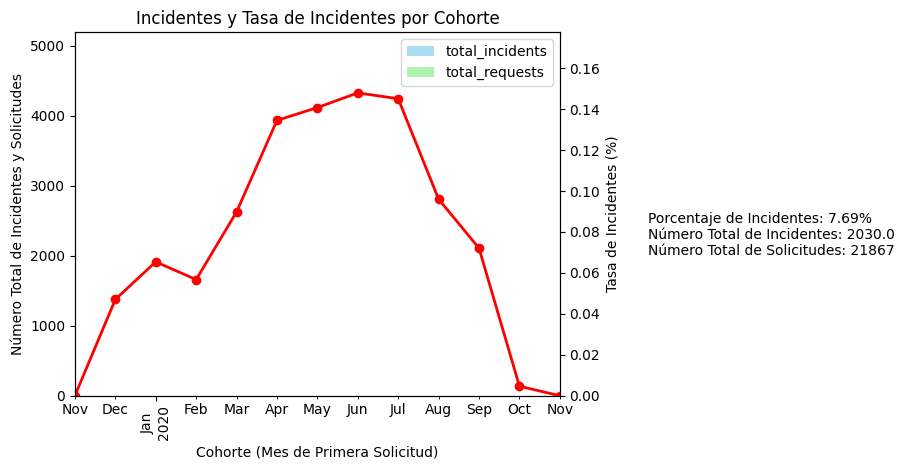

In [24]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Gráfico de barras para las cantidades absolutas de incidentes y solicitudes
cohort_incidents[['total_incidents', 'total_requests']].plot(kind='bar', ax=ax1, width=0.4, color=['skyblue', 'lightgreen'], alpha=0.7)

# Configurar el eje y secundario para la tasa de incidentes
ax2 = ax1.twinx()
cohort_incidents['incident_rate'].plot(kind='line', marker='o', ax=ax2, color='red', linewidth=2)

# Ajustar los límites del eje y secundario para mejorar la visibilidad de la línea
ax2.set_ylim(0, cohort_incidents['incident_rate'].max() * 1.2)

ax1.set_title('Incidentes y Tasa de Incidentes por Cohorte')
ax1.set_xlabel('Cohorte (Mes de Primera Solicitud)')
ax1.set_ylabel('Número Total de Incidentes y Solicitudes')
ax2.set_ylabel('Tasa de Incidentes (%)')

# Crear una leyenda personalizada en el lado derecho del gráfico
stats_text = f"Porcentaje de Incidentes: {cohort_incidents['incident_rate'].mean():.2%}\n" \
             f"Número Total de Incidentes: {cohort_incidents['total_incidents'].sum()}\n" \
             f"Número Total de Solicitudes: {cohort_incidents['total_requests'].sum()}"

# Añadir el texto como un cuadro de anotación dentro del gráfico
plt.gcf().text(1.02, 0.5, stats_text, fontsize=10, verticalalignment='center')

plt.xticks(rotation=45)
plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
plt.show()

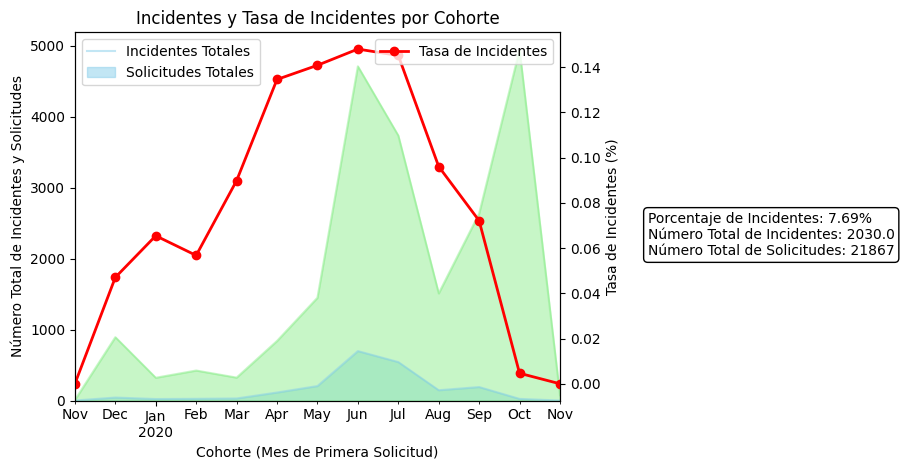

In [29]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Gráfico de área para las cantidades absolutas
cohort_incidents[['total_incidents', 'total_requests']].plot(kind='area', stacked=False, ax=ax1, alpha=0.5, color=['skyblue', 'lightgreen'])

# Línea para la tasa de incidentes
ax2 = ax1.twinx()
cohort_incidents['incident_rate'].plot(kind='line', marker='o', ax=ax2, color='red', linewidth=2)

ax1.set_title('Incidentes y Tasa de Incidentes por Cohorte')
ax1.set_xlabel('Cohorte (Mes de Primera Solicitud)')
ax1.set_ylabel('Número Total de Incidentes y Solicitudes')
ax2.set_ylabel('Tasa de Incidentes (%)')
ax1.legend(['Incidentes Totales', 'Solicitudes Totales'], loc='upper left')
ax2.legend(['Tasa de Incidentes'], loc='upper right')

# Crear una leyenda personalizada en el lado derecho del gráfico
stats_text = f"Porcentaje de Incidentes: {cohort_incidents['incident_rate'].mean():.2%}\n" \
             f"Número Total de Incidentes: {cohort_incidents['total_incidents'].sum()}\n" \
             f"Número Total de Solicitudes: {cohort_incidents['total_requests'].sum()}"

# Añadir el texto como un cuadro de anotación dentro del gráfico
plt.gcf().text(1.02, 0.5, stats_text, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.xticks(rotation=45)
plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
plt.show()
